In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit.visualization import plot_histogram
from ai_quantum.quantum.qaoa import QAOA
from ai_quantum.initialstates.dicke_initialstate import dicke_statevector
from ai_quantum.utils.matrix_compression import compress_matrix
from return_cov import f_return_cov
import networkx as nx

from ai_quantum.ai_models.gpt2 import GPT2_QAOA
import torch
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
expected_value, cov_matrix = f_return_cov()

## Cov Matrix compression

In [3]:
q_graph = [(2,3), (3, 0), (0, 4), (4, 1), (1, 2)]

In [4]:
G = nx.Graph()
G.add_edges_from(q_graph)
lam, compress_cov_matrix = compress_matrix(cov_matrix, G)

In [5]:
def f_loss(energies, sum_w):
    response = torch.mean((sum_w-energies).pow(2))
    return response

In [6]:
q = 0.5
B  = 2
lamb= 0
qc_initial_state = dicke_statevector(len(expected_value), B)

vocab_size = 10
max_depth = 30

In [7]:
nn_qaoa = GPT2_QAOA(vocab_size, 
                    max_depth, 
                    expected_value, 
                    compress_cov_matrix, 
                    q, 
                    B, 
                    lamb, 
                    qc=qc_initial_state,
                    mixture_layer='ring_mixer', 
                    q_graph=q_graph,
                    n_embd=768, 
                    n_layer=12, 
                    n_head=12
                    )
optimizer = optim.Adam(nn_qaoa.parameters(), lr=1e-4)

In [8]:
def epoch_train(
                model, 
                optimizer, 
                beta_temp, 
                depth, 
                full_input_ids=None, 
                energy_full_input_ids=None,
                scale_loss_term_min_energy=None, 
                precision=1e-3
               ):
    
    sum_w, energies, full_input_ids_min_temp0, gamma, beta = model.forward_qc(beta_temp, depth, precision=precision)
    energy_min_temp0 = energies.item()
    
    sum_w_, energy_, _, gamma, beta = model.forward_qc(-beta_temp, depth, precision=precision)
    if energy_.item() < energy_min_temp0:
        energy_min_temp0 = energy_.item()
        full_input_ids_min_temp0 = _
    sum_w = torch.cat((sum_w, sum_w_), dim=0)
    energies = torch.cat((energies, energy_), dim=0)
    
    sum_w_, energy_, _, gamma, beta = model.forward_qc(1, depth, full_input_ids, precision=precision)
    if np.inf > energy_full_input_ids:
        energy_ = torch.tensor([energy_full_input_ids])
    if scale_loss_term_min_energy is not None:
        sum_w_ = scale_loss_term_min_energy(sum_w_, energy_)*sum_w_
        energy_ = scale_loss_term_min_energy(sum_w_, energy_)*energy_
    sum_w = torch.cat((sum_w, sum_w_), dim=0)
    energies = torch.cat((energies, energy_), dim=0)
    
    optimizer.zero_grad()
    loss = f_loss(energies, sum_w)
    loss.backward()
    optimizer.step()
    
    return loss.item(), energies, sum_w, energy_min_temp0, full_input_ids_min_temp0

## Model Training

In [9]:
depth = 10
beta_temp = 1
epochs = 30
precision=1e-3

In [10]:
def scale_loss_term_min_energy(sum_w_, energy_):
    return 2
    if sum_w_ > energy_:
        return 2
    else:
        return 1

In [11]:
energy_min = np.inf
full_input_ids_min = None
for i in range(epochs):
    (
     loss_i, 
     energy, 
     sum_w, 
     energy_min0, 
     full_input_ids_min0
    ) = epoch_train(
                    nn_qaoa, 
                    optimizer, 
                    beta_temp, 
                    depth, 
                    full_input_ids_min, 
                    energy_min, 
                    scale_loss_term_min_energy, 
                    precision
                   )
    
    if energy_min0 < energy_min:
        energy_min = energy_min0
        full_input_ids_min = full_input_ids_min0
        
    nn_qaoa.eval()
    with torch.no_grad():
        response = nn_qaoa.forward_qc(1, depth, full_input_ids_min)
        
    str_print = f"Epoch {i}, "
    str_print = str_print + f"Loss: {loss_i:.2f}, "
    str_print = str_print + f"energy_min0: {energy_min0:.2f}, "
    str_print = str_print + f"energy_min: {energy_min:.2f}"
    print(str_print)


Epoch 0, Loss: 62.41, energy_min0: -0.00, energy_min: -0.00
Epoch 1, Loss: 13357.58, energy_min0: -0.21, energy_min: -0.21
Epoch 2, Loss: 12945.72, energy_min0: -0.02, energy_min: -0.21
Epoch 3, Loss: 2279.77, energy_min0: 0.07, energy_min: -0.21
Epoch 4, Loss: 2880.59, energy_min0: -0.02, energy_min: -0.21
Epoch 5, Loss: 1426.80, energy_min0: 0.06, energy_min: -0.21
Epoch 6, Loss: 479.65, energy_min0: -0.05, energy_min: -0.21
Epoch 7, Loss: 250.50, energy_min0: 0.05, energy_min: -0.21
Epoch 8, Loss: 354.34, energy_min0: -0.06, energy_min: -0.21
Epoch 9, Loss: 607.76, energy_min0: -0.05, energy_min: -0.21
Epoch 10, Loss: 666.46, energy_min0: -0.04, energy_min: -0.21
Epoch 11, Loss: 569.83, energy_min0: -0.01, energy_min: -0.21
Epoch 12, Loss: 435.69, energy_min0: 0.02, energy_min: -0.21
Epoch 13, Loss: 286.99, energy_min0: -0.02, energy_min: -0.21
Epoch 14, Loss: 118.34, energy_min0: -0.04, energy_min: -0.21
Epoch 15, Loss: 44.11, energy_min0: -0.05, energy_min: -0.21
Epoch 16, Loss: 1

In [12]:
sum_w_, energy_, _, gamma, beta = nn_qaoa.forward_qc(1, depth, full_input_ids_min, precision=precision)
count = nn_qaoa.get_counts_qc(1, depth, full_input_ids_min, shots=1000)


sum_w_, energy_min

(tensor([4.4094], grad_fn=<AddBackward0>), -0.21301662921905518)

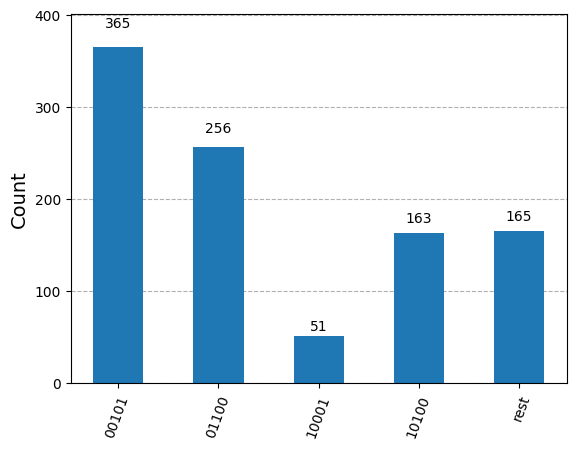

In [13]:
plot_histogram(count, number_to_keep=4)
plt.show()